# Main 

## Check Setup

In [1]:
from helpers_functions.setup import *

path_archive = "archive"

path_train_val_list = "archive/train_val_list_NIH.txt"
path_test_list = "archive/test_list_NIH.txt"

path_all_data_csv = "archive/Data_Entry_2017.csv"

path_folder_images = "archive/images-224/images-224"

### Check structure

In [2]:
import json

path = path_archive
print(json.dumps(list_tree(path, max_depth=1), indent=2))


{
  "_files": [
    "BBox_List_2017_Official_NIH.csv",
    "test_list_NIH.txt",
    "pretrained_model.h5",
    "train_val_list_NIH.txt",
    "Data_Entry_2017.csv"
  ],
  "images-224": {
    "images-224": "..."
  }
}


## Data Preprocessing

### Create class-label linking

In [3]:
from helpers_functions.multi_hot import *

class_label_str_to_idx, class_label_idx_to_str = create_class_mappings(path_all_data_csv)

print(class_label_str_to_idx)
print(class_label_idx_to_str)

{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Hernia': 7, 'Infiltration': 8, 'Mass': 9, 'No Finding': 10, 'Nodule': 11, 'Pleural_Thickening': 12, 'Pneumonia': 13, 'Pneumothorax': 14}
{0: 'Atelectasis', 1: 'Cardiomegaly', 2: 'Consolidation', 3: 'Edema', 4: 'Effusion', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Hernia', 8: 'Infiltration', 9: 'Mass', 10: 'No Finding', 11: 'Nodule', 12: 'Pleural_Thickening', 13: 'Pneumonia', 14: 'Pneumothorax'}


### Multi-hot encoding

In [4]:
# Assume class_to_idx and idx_to_class are already created
image_to_multihot = create_image_multihot_mapping_from_dicts(path_all_data_csv, class_label_str_to_idx)

# Check the first image mapping
first_image = list(image_to_multihot.keys())[0]
print(first_image, image_to_multihot[first_image])


00000001_000.png [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Modeling

#### Make a Dataloader

Image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8, 15])
First image name: 00016048_000.png
First label vector: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])


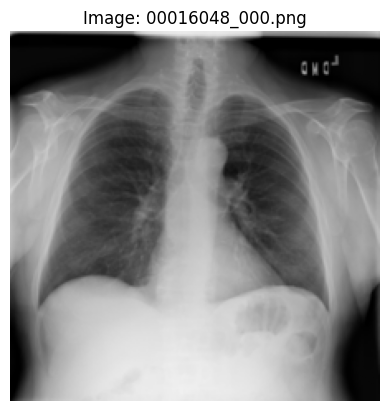

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class MedicalImageDataset(Dataset):
    """
    PyTorch Dataset for medical images with precomputed multi-hot labels.

    Each sample returns:
        - image tensor
        - multi-hot label vector
        - image file name
    """
    def __init__(self, files_list_dir: str, img_dir: str, image_to_multihot: dict, transform=None):
        """
        Args:
            files_list_dir (str): Path to a .txt file with each row being an image name.
            img_dir (str): Directory containing the images.
            image_to_multihot (dict): Precomputed dictionary mapping image name → multi-hot vector.
            transform (callable, optional): Optional transform to apply to images.
        """
        # Load image names from txt
        with open(files_list_dir, "r") as f:
            self.image_names = [line.strip() for line in f if line.strip()]

        self.img_dir = img_dir
        self.image_to_multihot = image_to_multihot
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        # Ensure no infinite loop
        if idx >= 2 * len(self):
            raise FileNotFoundError(f"No valid images.")

        img_name = self.image_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        # Skip missing images
        if not os.path.exists(img_path):
            print(f"Warning: Image file '{img_path}' not found. Skipping to next index.")
            return self.__getitem__((idx + 1) % len(self))  # wrap around if at end


        # Load image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        else:
            # Default conversion to tensor
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float() / 255.0

        # Get multi-hot vector from precomputed dictionary
        multi_hot = torch.from_numpy(
            self.image_to_multihot.get(
                img_name,
                np.zeros(len(next(iter(self.image_to_multihot.values()))),
                dtype=np.float32)
            )
        )

        return image, multi_hot, img_name


# Create Dataset and DataLoader
dataset = MedicalImageDataset(path_train_val_list, path_folder_images, image_to_multihot)

loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Get the first batch
imgs, multi_hot, names = next(iter(loader))

print("Image batch shape:", imgs.shape)
print("Label batch shape:", multi_hot.shape)
print("First image name:", names[0])
print("First label vector:", multi_hot[0])

# Display the first image in the batch
plt.imshow(imgs[0].permute(1, 2, 0))
plt.title(f"Image: {names[0]}")
plt.axis('off')
plt.show()


#### Create CNN

In [6]:
from models.models import *

model_name = "Mo_Ex"
model = models(model_name)

print(model)

MoExResNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

/Users/leoyu/VScode Programs/ECE 685D/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/leoyu/VScode Programs/ECE 685D/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#### Train the CNN

In [7]:
from models.train import *
from models.val import *
import torch
from torch.utils.data import random_split

# Train Parameters
epochs = 10
val_every = 5
batch_size = 16
save = False
save_every = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Split the dataset into train and val
val_ratio = 0.2
total_size = len(dataset)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size
torch.manual_seed(42) # Set seed for reproducibility

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


# Train model
for epoch in range(0, epochs, val_every):
    train(
        model_name,
        model, 
        optimizer,
        train_dataset, start_epoch=epoch, end_epoch=min(epoch+val_every, epochs),
        batch_size=batch_size, device=device, 
        save=save, save_every=save_every, checkpoint_dir=f"checkpoints/{model_name}"
    )
    
    val(model_name, 
        model, 
        val_dataset, epoch=epoch+val_every, 
        batch_size=batch_size, device=device
    )


Train dataset size: 69220
Validation dataset size: 17304


Epoch 1/5:   0%|          | 9/4327 [00:08<1:11:18,  1.01batch/s, loss=0.233]


KeyboardInterrupt: 

#### Classifier Performance

Image batch shape: torch.Size([8, 3, 224, 224])
Label batch shape: torch.Size([8, 15])
First image name: 00016975_013.png
First label vector: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])


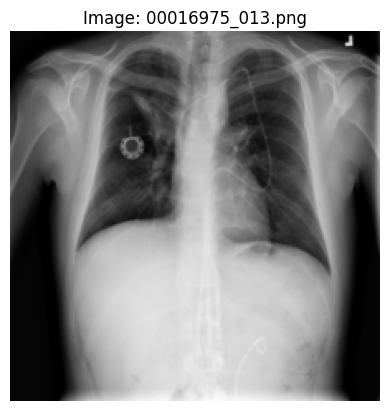

In [8]:
# Create Dataset and DataLoader
test_dataset = MedicalImageDataset(path_test_list, path_folder_images, image_to_multihot)

test_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Get the first batch
imgs, multi_hot, names = next(iter(test_loader))

print("Image batch shape:", imgs.shape)
print("Label batch shape:", multi_hot.shape)
print("First image name:", names[0])
print("First label vector:", multi_hot[0])

# Display the first image in the batch
plt.imshow(imgs[0].permute(1, 2, 0))
plt.title(f"Image: {names[0]}")
plt.axis('off')
plt.show()


In [9]:
from helpers_functions.metrics import *
from models.pred import *

preds, labels = pred(
    model_name=model_name, 
    model=model, 
    dataset=train_dataset)
df = evaluate(preds, labels)

print(json.dumps(df.to_dict(), indent=2))

KeyboardInterrupt: 